In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', 25)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
 
movie = pd.read_csv('data/tmdb_5000_movies.csv')
credit = pd.read_csv('data/tmdb_5000_credits.csv')
credit.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [2]:
credit.columns = ['id','cast', 'title', 'crew']
movie= movie.merge(credit, on='id')
movie.head()
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

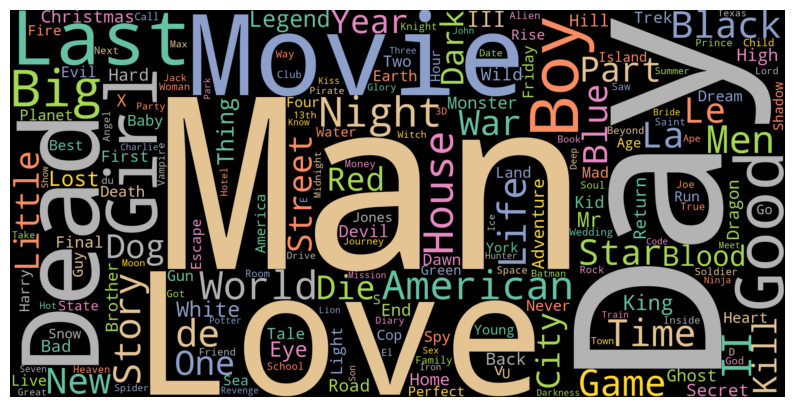

In [3]:
def cloud(col):    
    wcloud = " ".join(f for f in movie[col])
    wc_ = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = STOPWORDS)
    wc_.generate(wcloud)
    plt.subplots(figsize=(10,6))
    plt.imshow(wc_, interpolation="bilinear")
    plt.axis("off")

cloud("original_title")

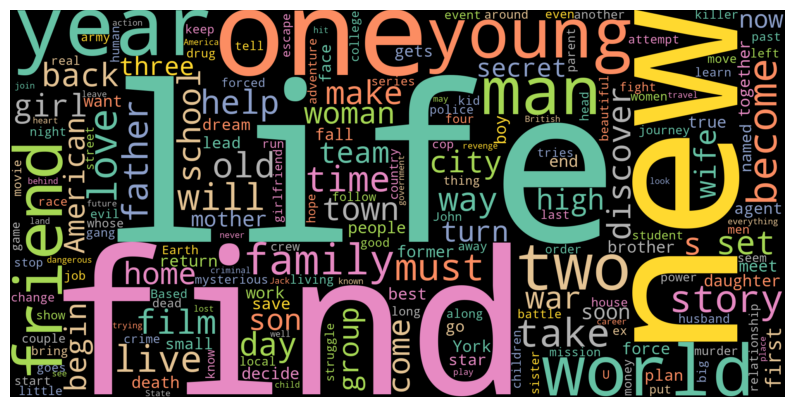

In [4]:
movie["overview"] = movie["overview"].fillna("")
cloud("overview")

In [5]:
tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(movie["overview"])
tfidf_matrix

<4803x20978 sparse matrix of type '<class 'numpy.float64'>'
	with 125840 stored elements in Compressed Sparse Row format>

In [6]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
# 索引和电影original_title的反向映射
indices = pd.Series(movie.index, index=movie['original_title']).drop_duplicates()

In [7]:
def get_recommendation(title, cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movies = [i[0] for i in sim_scores]
    movies = movie["original_title"].iloc[movies]
    return movies
get_recommendation('Spectre', cosine_sim)

1343    Never Say Never Again
4071    From Russia with Love
3162              Thunderball
1717               Safe Haven
11          Quantum of Solace
4339                   Dr. No
29                    Skyfall
1880              Dance Flick
3336     Diamonds Are Forever
1743                Octopussy
Name: original_title, dtype: object

In [8]:
get_recommendation("John Carter", cosine_sim)

1254                          Get Carter
4161         The Marine 4: Moving Target
2932                        Raising Cain
3349                           Desperado
1307                       The Hurricane
3068                         Rescue Dawn
345                          Rush Hour 2
581              Star Trek: Insurrection
2998                               Devil
4274    Eddie: The Sleepwalking Cannibal
Name: original_title, dtype: object

In [9]:
from ast import literal_eval
 
features = ['keywords', 'genres']
for feature in features:
    movie[feature] = movie[feature].apply(literal_eval)
 
movie[['original_title', 'keywords', 'genres']].head(3)

def list_genres(x):
    l = [d['name'] for d in x]
    return(l)
movie['genres'] = movie['genres'].apply(list_genres)
 
def list_keyword(y):
    i = [a['name'] for a in y]
    return(i)
movie['keywords'] = movie['keywords'].apply(list_keyword)

def genre(x):
    return ''.join(' '.join(x['genres']) + ' ' + ' '.join(x['keywords']))
 
movie['mix'] = movie.apply(genre, axis=1)
movie["mix"]

0       Action Adventure Fantasy Science Fiction cultu...
1       Adventure Fantasy Action ocean drug abuse exot...
2       Action Adventure Crime spy based on novel secr...
3       Action Crime Drama Thriller dc comics crime fi...
4       Action Adventure Science Fiction based on nove...
                              ...                        
4798    Action Crime Thriller united states–mexico bar...
4799                                      Comedy Romance 
4800    Comedy Drama Romance TV Movie date love at fir...
4801                                                     
4802     Documentary obsession camcorder crush dream girl
Name: mix, Length: 4803, dtype: object

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
countvect = CountVectorizer(stop_words="english")
countvect_mat = tfidf.fit_transform(movie["mix"])
countvect_mat

<4803x7069 sparse matrix of type '<class 'numpy.float64'>'
	with 60983 stored elements in Compressed Sparse Row format>

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(countvect_mat, countvect_mat)
movie = movie.reset_index()
indices = pd.Series(movie.index, index=movie['original_title'])
get_recommendation("John Carter", cos_sim)

373           Mission to Mars
2964    The Last Days on Mars
754                 Planet 51
141           Mars Needs Moms
487                Red Planet
1319                  Riddick
752       My Favorite Martian
0                      Avatar
278        Planet of the Apes
541                   Soldier
Name: original_title, dtype: object

In [12]:
get_recommendation("Soldier", cos_sim)

1319                      Riddick
0                          Avatar
278            Planet of the Apes
754                     Planet 51
2047    Megiddo: The Omega Code 2
193                   After Earth
1642                       Splice
838                        Alien³
3158                        Alien
4332               Silent Running
Name: original_title, dtype: object

In [13]:
avg = movie["vote_average"].mean()
q = movie["vote_count"].quantile(0.9)
print(avg)
print(q)

6.092171559442016
1838.4000000000015


In [14]:
movies = movie[movie["vote_count"] >= q]
def weighted_rating(x, q=q, avg=avg):
    v = x['vote_count']
    R = x['vote_average']
    # 根据IMDB公式计算
    return (v/(v+q) * R) + (q/(q+v) * avg)
 
movies["score"] = movies.apply(weighted_rating, axis=1)

movies = movies.sort_values('score', ascending=False)

listed = movies[['original_title', 'vote_count', 'vote_average', 'score', "popularity"]].head(10)
listed

,original_title,vote_count,vote_average,score,popularity
1881,The Shawshank Redemption,8205,8.5,8.059258,136.747729
662,Fight Club,9413,8.3,7.939256,146.757391
65,The Dark Knight,12002,8.2,7.920020,187.322927
3232,Pulp Fiction,8428,8.3,7.904645,121.463076
96,Inception,13752,8.1,7.863239,167.583710
3337,The Godfather,5893,8.4,7.851236,143.659698
95,Interstellar,10867,8.1,7.809479,724.247784
809,Forrest Gump,7927,8.2,7.803188,138.133331
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243,123.630332
1990,The Empire Strikes Back,5879,8.2,7.697884,78.517830


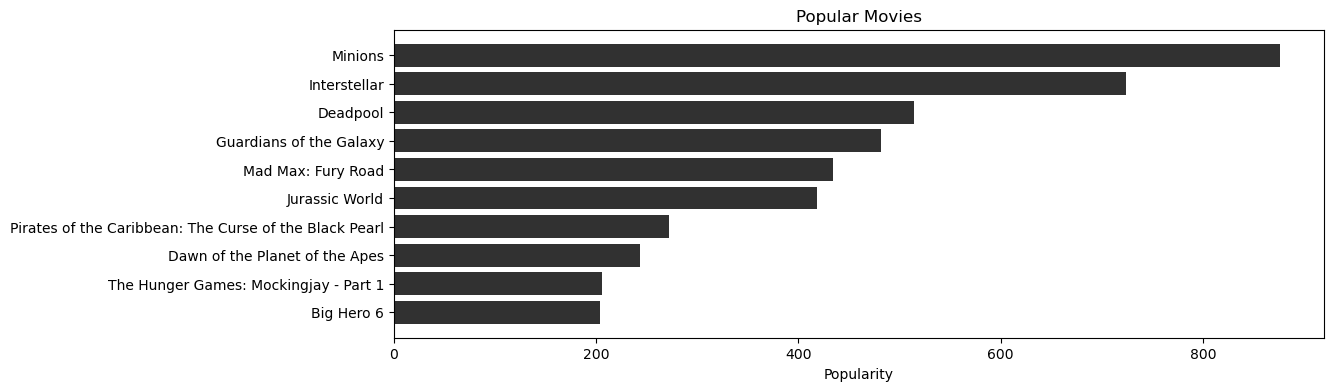

In [16]:
import seaborn as sns

popular= movies.sort_values('popularity', ascending=False)
plt.figure(figsize=(12,4))
 
plt.barh(popular['original_title'].head(10),popular['popularity'].head(10), align='center',
        color="#313131")
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")
plt.show()